# Create media designs using Latin Hypercube for LCMS flaviolin experiment

This notebook generates a set of media designs using Latin Hypercube sampling. We use ART's capability to provide this kind of designs for media components for which to get phenotypic data. We will use two types of assays for this experiment - absorbance at 340nm and LCMS measurements.  


We include a design that is very close to the standard media (up to 5% variation for each component), as a control for every cycle.

Tested using **ART 3.9.4** kernel on jprime.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds.csv`
- `standard_recipe_concentrations.csv`

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [34]:
import os
import sys
# sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
# sys.path.append('../../media_compiler')
import re
import warnings
 
import matplotlib.pyplot as plt
import shap

from art.core import * 
import art.utility as utils
import edd_utils as eddu


## User parameters

In [2]:
CYCLE = 6

user_params = {
    'bounds_file': f'../data/Putida_media_bounds.csv',
    'output_file_path': f'../data/DBTL{CYCLE}', # Folder for output files,
}

Specify which components to explore:

In [3]:
user_params['components'] = [
    'H3BO3',
    'K2SO4',
    'K2HPO4',
    'FeSO4',
    'NH4Cl',
    'MgCl2',
    'NaCl',
    '(NH4)6Mo7O24',
    'CoCl2',
    'CuSO4',
    'MnSO4',
    'ZnSO4'
]

user_params['response'] = 'OD340'

In [4]:
user_params['study_slug_1'] = 'combinatorial-media-for-flaviolin-dbtl1-ed1e'
user_params['study_slug_2'] = 'combinatorial-media-for-flaviolin-dbtl-2'
user_params['study_slug_3'] = 'combinatorial-media-for-flaviolin-dbtl-3'
user_params['study_slug_4'] = 'combinatorial-media-for-flaviolin-dbtl-4'
user_params['study_slug_5'] = 'combinatorial-media-for-flaviolin-dbtl-5'

user_params['edd_server'] = 'edd.jbei.org'
user_params['username'] = 'tradivojevic'


## Load the data

In [5]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']
edd_server = user_params['edd_server']
username = user_params['username']

In [6]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [7]:
warnings.filterwarnings("ignore")

In [8]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')


100%|██████████| 96/96 [00:00<00:00, 2934.11it/s]


Concatenate the five studies:

In [9]:
df = df_1.append(df_2).append(df_3).append(df_4).append(df_5)

Drop unnecessary columns:

In [10]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


Pivot the dataframe to include columns for all protocols:

In [11]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Protocol", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


## Train ART on all previous data (DBTL 1-5)

### Adding media information to the data frame

Add columns for each component:

In [12]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None


And assign values for each component and line:

In [13]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
235,C5_WD7_F7-R2,0.6091,0.708,40.0,4.0,0.037489,20.0,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037
236,C5_WD7_F7-R3,0.6303,0.445,40.0,4.0,0.037489,20.0,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037
237,C5_WD8_F8-R1,0.2476,1.469,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109
238,C5_WD8_F8-R2,0.2498,1.283,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109
239,C5_WD8_F8-R3,0.2316,0.863,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109


### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [17]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS,40.0
3,C1_WA1_A4-R1,Tricine,4.0
4,C1_WA1_A4-R1,H3BO3,0.003744


### ART training

Define a dictionary that contains the settings that ART will use to generate a predictive model:

In [39]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']),
    'seed': 10,                                           # seed for number random generator
    'cross_val': False,
    'num_tpot_models': 4,
    'recommend': False,
    'output_directory': user_params['output_file_path'],  # directory to store this output
    'verbose': 1,
}

With the configuration stored in art_params, we now run ART:

In [32]:
run_art = True

Dataframe does not have a time column matching one of the supported formats. Assuming that all data in the file comes from a single time point.


Fitting L0 models…
Best pipeline: RidgeCV(CombineDFs(Binarizer(input_matrix, threshold=0.8500000000000001), RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=14, min_samples_split=3, n_estimators=100)))
Best pipeline: LinearSVR(ZeroCount(ElasticNetCV(input_matrix, l1_ratio=0.5, tol=0.01)), C=20.0, dual=True, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.01)
Best pipeline: RidgeCV(CombineDFs(input_matrix, GradientBoostingRegressor(input_matrix, alpha=0.9, learning_rate=0.1, loss=quantile, max_depth=6, max_features=0.8500000000000001, min_samples_leaf=18, min_samples_split=14, n_estimators=100, subsample=0.2)))
Best pipeline: GradientBoostingRegressor(MinMaxScaler(LinearSVR(input_matrix, C=0.001, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.01)), alpha=0.99, learning_rate=0.1, loss=huber, max_depth=10, max_features=0.3, min_samples_leaf=18, min_samples_split=11, n_estimators=100, subsample=0.7000000000000001)
Done fitting L0 mo

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 107 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Done building ensemble model in 309.30 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.071531,17.170401,0.057581,0.008432,0.594488
Random Forest Regressor,0.014496,3.302913,0.014225,0.000412,0.980163
Support Vector Regressor,0.060299,16.022328,0.031117,0.004604,0.778582
Kernel Ridge Regressor,0.026860,6.201236,0.023790,0.001287,0.938086
K-NN Regressor,0.025754,6.427141,0.023811,0.001230,0.940836
Gaussian Process Regressor,0.014957,3.479483,0.014082,0.000422,0.979705
Gradient Boosting Regressor,0.014689,3.358970,0.014157,0.000416,0.979985
TPOT Regressor,0.034855,8.374142,0.030222,0.002128,0.897650
TPOT Regressor,0.051052,11.980508,0.047315,0.004845,0.766999


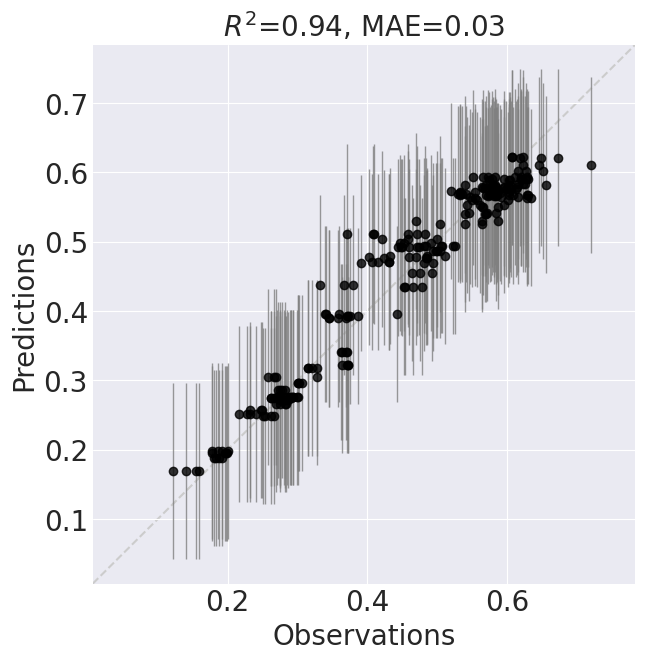

CPU times: user 18min 27s, sys: 8 s, total: 18min 35s
Wall time: 23min 8s


In [42]:
%%time
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(user_params['output_file_path'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

## Explaining ART model with Shapley values

Shapley values are a widely used approach from cooperative game theory. 

In [44]:
shap.initjs()

In [45]:
plt.style.use('default')

Define the function for our predictions:

In [46]:
def f(X):
    return art.predict(X)

In [47]:
X_df = pd.DataFrame(data=art.X, columns=user_params['components'])

### Explainer

In [48]:
%%time
explainer_e = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

Permutation explainer: 241it [07:25,  1.89s/it]                         

CPU times: user 7min 25s, sys: 587 ms, total: 7min 25s
Wall time: 7min 25s


The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model's output $f(x)$ among its input features.

- Get all subsets that don’t contain the feature $i$
- Find the marginal contribution of the feature $i$ to each of these subsets
- Aggregate all marginal contributions to compute the contributions of the feature $i$
- For each of these subsets, SHAP doesn’t remove a feature then retrain the model but replaces that feature with the average value of that feature, then generates the predictions.

One the fundemental properties of Shapley values of all the input features is that they always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

All SHAP values have the same unit – the unit of the prediction space. 

**Local bar plot**

How much did each feature contribute to the difference between the specific prediction and the average prediction? 

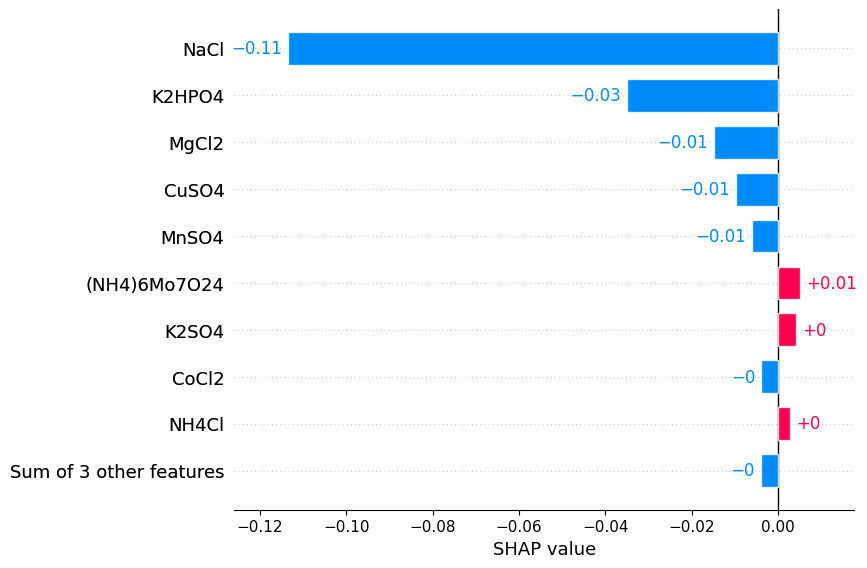

In [49]:
sample_ind = 5
shap.plots.bar(shap_values_e[sample_ind])

Passing a matrix of SHAP values to the bar plot function creates a **global** feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

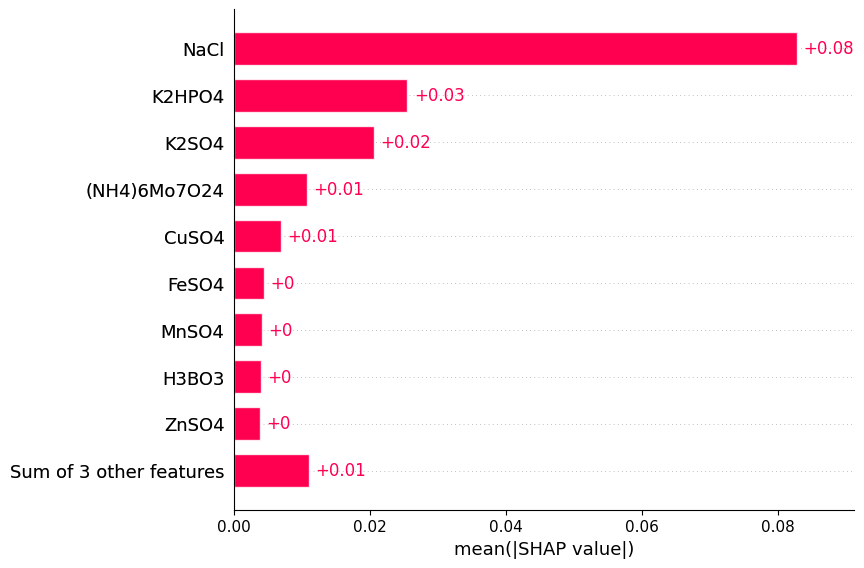

In [50]:
shap.plots.bar(shap_values_e)

But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value places MgCl2 as the 5th feature

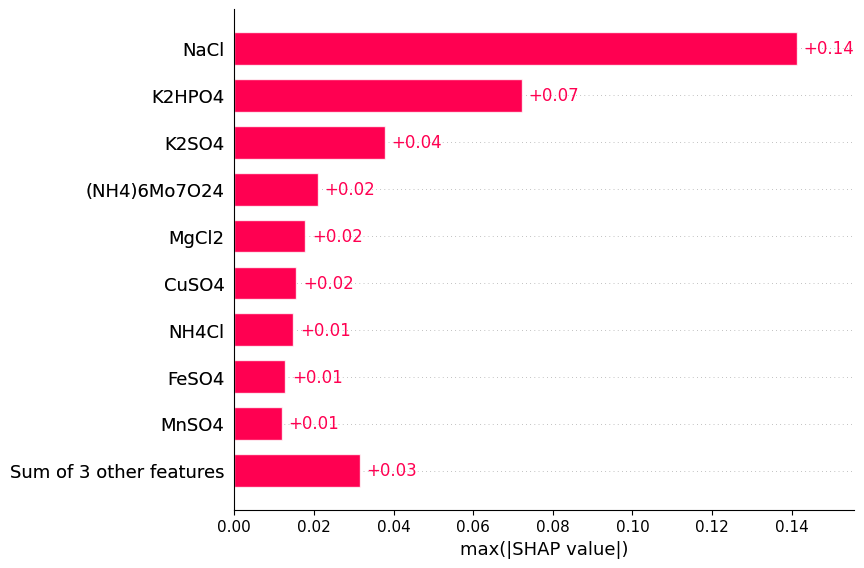

In [51]:
shap.plots.bar(shap_values_e.abs.max(0))

To inspect the global importance of each feature in the model for all instances we run:

**Layered violin plot**

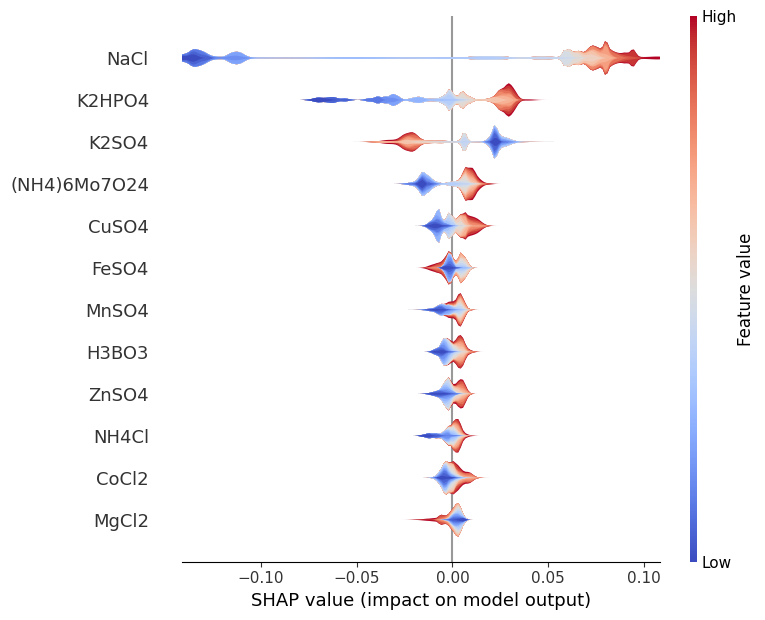

In [62]:
shap.summary_plot(shap_values_e, plot_type="layered_violin")

**Violin plot**

These are a standard violin plot but with outliers drawn as points.

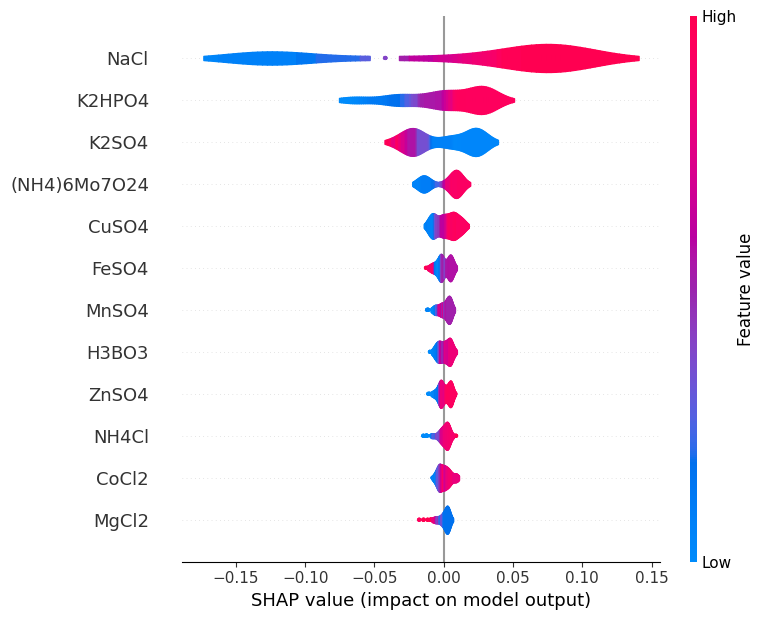

In [63]:
shap.summary_plot(shap_values_e, plot_type="violin")

**Dot plot**

This combines a scatter plot with density estimation by letting dots pile up when they don’t fit. The advatange of this approach is that it does not hide anything behind kernel smoothing, so what-you-see-is-what-is-there.

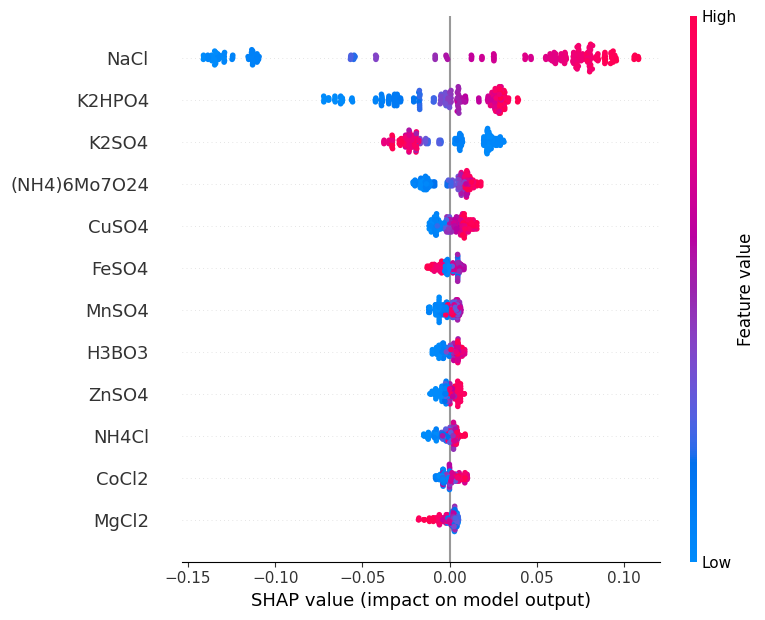

In [52]:
shap.summary_plot(shap_values_e)


This bar plot shows that NaCl, K2HPO4, K2SO4 are the top three factors driving the model's prediction of OD340

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale. By default the samples are ordered using shap.order.hclust, which orders the samples based on a hierarchical clustering by their explanation similarity. This results in samples that have the same model output for the same reason getting grouped together.

The output of the model is shown above the heatmap matrix (centered around the explaination's .base_value), and the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this is the shap.order.abs.mean measure of overall importance).

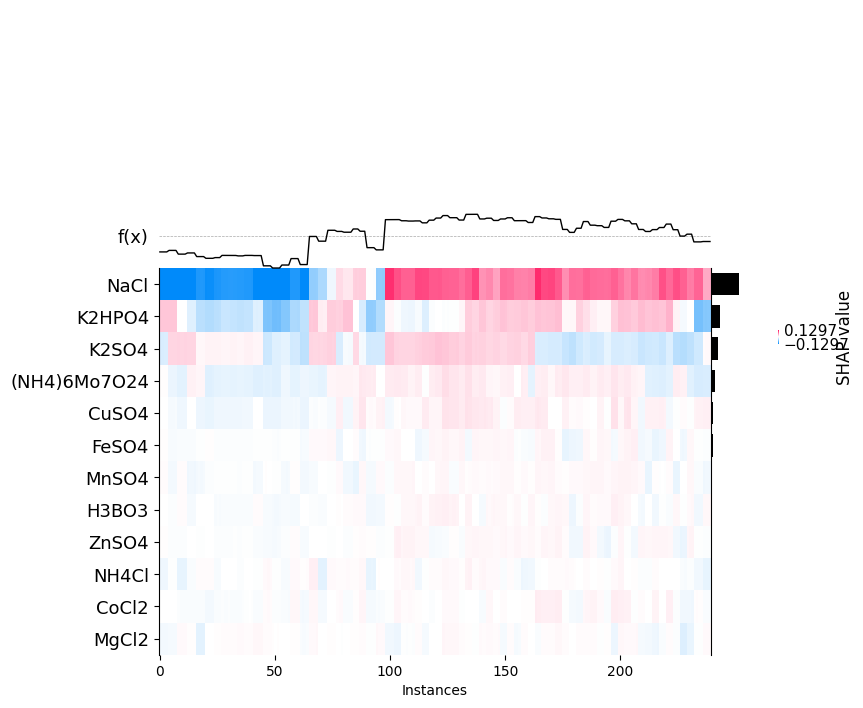

In [53]:
shap.plots.heatmap(shap_values_e, max_display=12)

We can also control the ordering of the instances using the instance_order parameter. By default it is set to shap.Explanation.hclust(0) to group samples with similar explantions together. We can also sort by the sum of the SHAP values over all features:

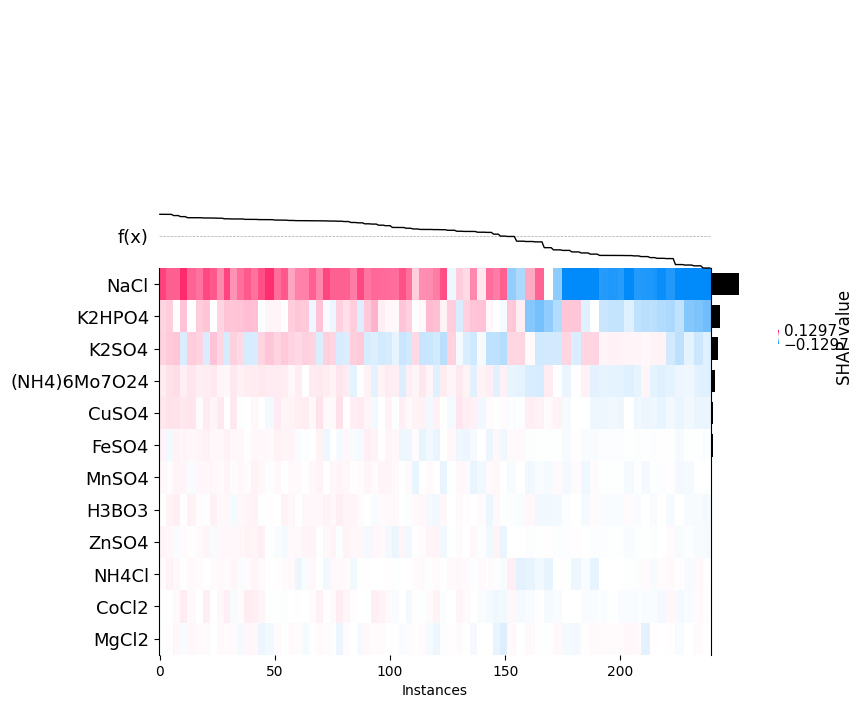

In [54]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=12)

In [59]:
for name in X_df.columns:
    shap.dependence_plot(name, shap_values_e[0], X_df)

TypeError: order must be str, not int

In [55]:
shap_values_e

.values =
array([[-0.00366309,  0.02170515,  0.0091077 , ..., -0.00215696,
         0.00043763,  0.00042969],
       [-0.00355633,  0.02124723,  0.0091588 , ..., -0.00216751,
         0.00047125,  0.00035129],
       [-0.0035814 ,  0.02132221,  0.00929086, ..., -0.0019983 ,
         0.00044969,  0.00039329],
       ...,
       [-0.00407315,  0.00658741, -0.03441808, ..., -0.00861976,
        -0.00198318, -0.00228739],
       [-0.00416664,  0.00665723, -0.0349005 , ..., -0.0087094 ,
        -0.00186031, -0.00232135],
       [-0.00403143,  0.00658944, -0.03495195, ..., -0.00852928,
        -0.00190738, -0.00234598]])

.base_values =
array([[0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
       [0.4405283],
 

### Kernel Explainer

Set the explainer using the Kernel Explainer (Model agnostic explainer method form SHAP)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model.

In [91]:
explainer_kernel = shap.KernelExplainer(model=f, data=X_df)


Using 240 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [92]:
%%time
shap_values_kernel = explainer_kernel.shap_values(X=X_df, nsamples=100) # runs ART 100 times for each prediction

100%|██████████| 240/240 [03:43<00:00,  1.07it/s]

CPU times: user 3min 25s, sys: 19 s, total: 3min 44s
Wall time: 3min 43s


In [93]:
%%time
shap_values_kernel = explainer_kernel.shap_values(X=X_df) # runs ART 10 times

100%|██████████| 240/240 [1:10:54<00:00, 17.73s/it]

CPU times: user 1h 1min 40s, sys: 9min 30s, total: 1h 11min 11s
Wall time: 1h 10min 54s


A summary plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high Feature 6 (NaCl) increases the predicted OD340.

Instead of looking at each individual instance, we can visualize the overall impact of these features across multiple instances using SHAP summary plot:

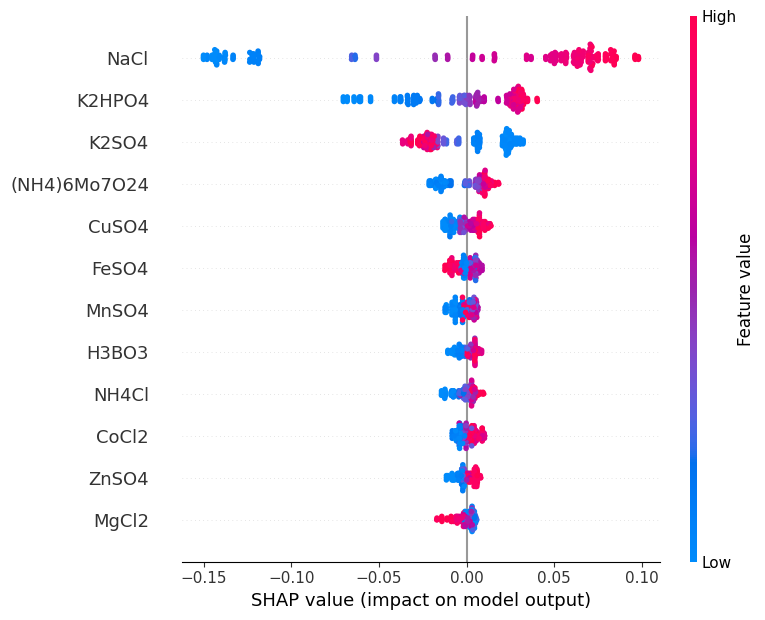

In [100]:
shap.summary_plot(shap_values=shap_values_kernel[0], features=X_df)

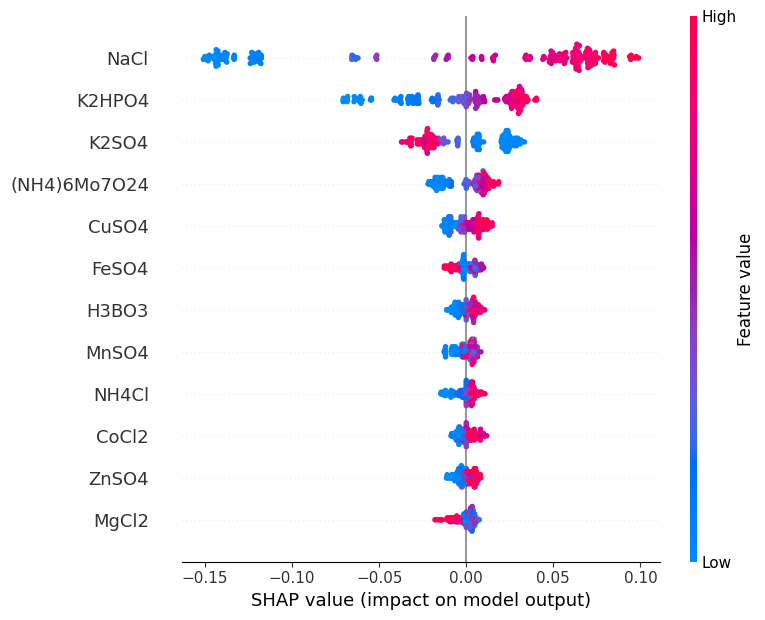

In [86]:
shap.summary_plot(shap_values=shap_values_kernel[0], features=X_df)

The SHAP summary plot tells us the most important features and their range of effects over the dataset.

Based on the above summary plot we can see that MnSO4 is the feature that have the least influence on the model and could be dropped if needed. This is the big advantage of SHAP since without this we would not have much insight into which features are actually influencing our model.

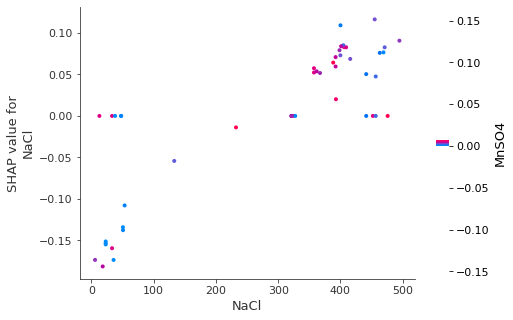

In [29]:
shap.dependence_plot("NaCl", shap_values[0], X_test)

A summary beeswarm plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

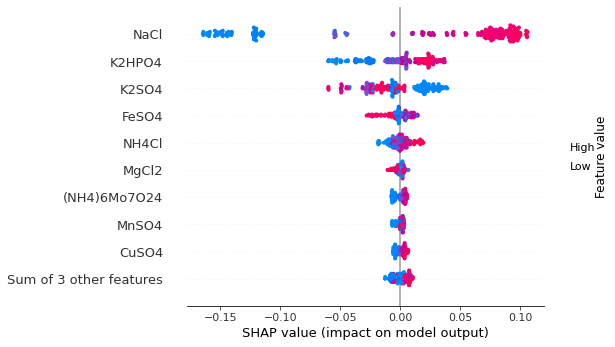

In [30]:
shap.plots.beeswarm(shap_values_e, order=shap_values_e.abs.max(0))

By taking the absolute value and using a solid color we get a compromise between the complexity of the bar plot and the full beeswarm plot. Note that the bar plots above are just summary statistics from the values shown in the beeswarm plots below.

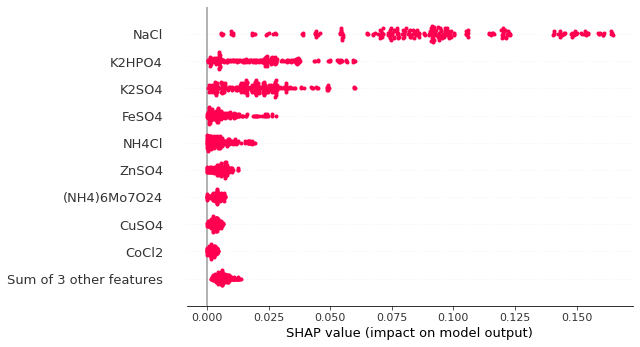

In [31]:
shap.plots.beeswarm(shap_values_e.abs, color="shap_red")

Dealing with correlated features

Using feature clustering

Often features in datasets are partially or fully redundant with each other. Where redudant means that a model could use either feature and still get same accuracy. To find these features practitioners will often compute correlation matrices among the features, or use some type of clustering method. When working with SHAP we recommend a more direct approach that measures feature redundancy through model loss comparisions. The shap.utils.hclust method can do this and build a hierarchical clustering of the feature by training XGBoost models to predict the outcome for each pair of input features. For typical tabular dataset this results in much more accurate measures of feature redundancy than you would get from unsupervised methods like correlation.


Once we compute such a clustering we can then pass it to the bar plot so we can simultainously visualize both the feature redundancy structure and the feature importances. Note that by default we don't show all of the clustering structure, but only the parts of the clustering with distance < 0.5. Distance in the clustering is assumed to be scaled roughly between 0 and 1, where 0 distance means the features perfectly redundant and 1 means they are completely independent. In the plot below we see that only relationship and marital status have more that 50% redundany, so they are the only features grouped in the bar plot:

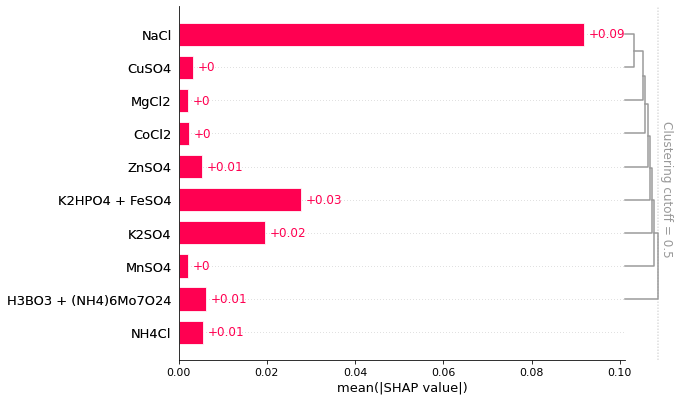

In [32]:
clustering = shap.utils.hclust(X_df, art.y) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values_e, clustering=clustering)

### Exact Explainer

The Exact explainer is model-agnostic, so it can compute Shapley values and Owen values exactly (without approximation) for any model. 

In [87]:
%%time
explainer_exact = shap.explainers.Exact(f, X_df)
shap_values_exact = explainer_exact(X_df)

Exact explainer: 241it [49:36, 12.40s/it]                         

CPU times: user 42min 26s, sys: 7min 10s, total: 49min 37s
Wall time: 49min 36s


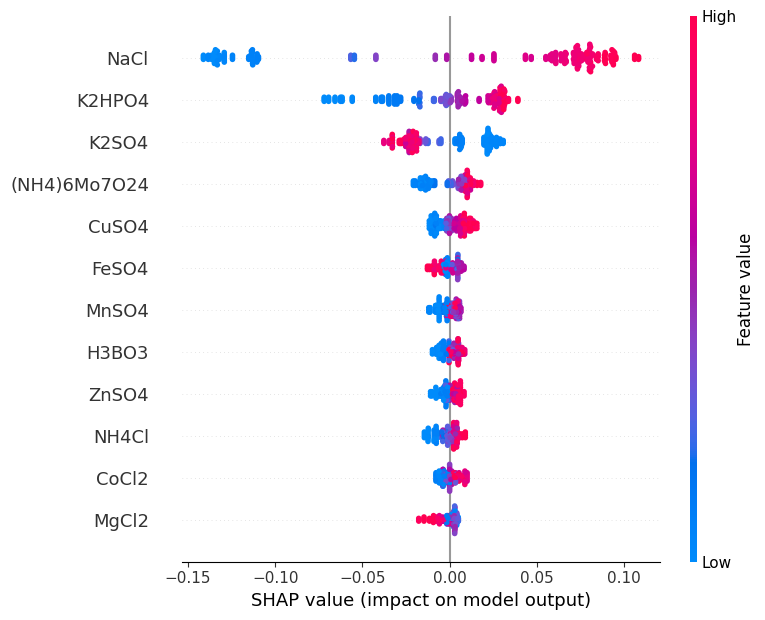

In [88]:
shap.summary_plot(shap_values_exact)

### Permutation Explainer 

The Permutation explainer is also model-agnostic. This method approximates the Shapley values by iterating through permutations of the inputs.

Because the Permutation explainer has important performance optimizations, and does not require regularization parameter tuning like Kernel explainer, the Permutation explainer is the default model agnostic explainer used for tabular datasets that have more features than would be appropriate for the Exact explainer.

In [89]:
%%time
explainer_perm = shap.explainers.Permutation(f, X_df)
shap_values_perm = explainer_perm(X_df)


Permutation explainer: 241it [07:19,  1.87s/it]                         

CPU times: user 7min 19s, sys: 375 ms, total: 7min 19s
Wall time: 7min 19s


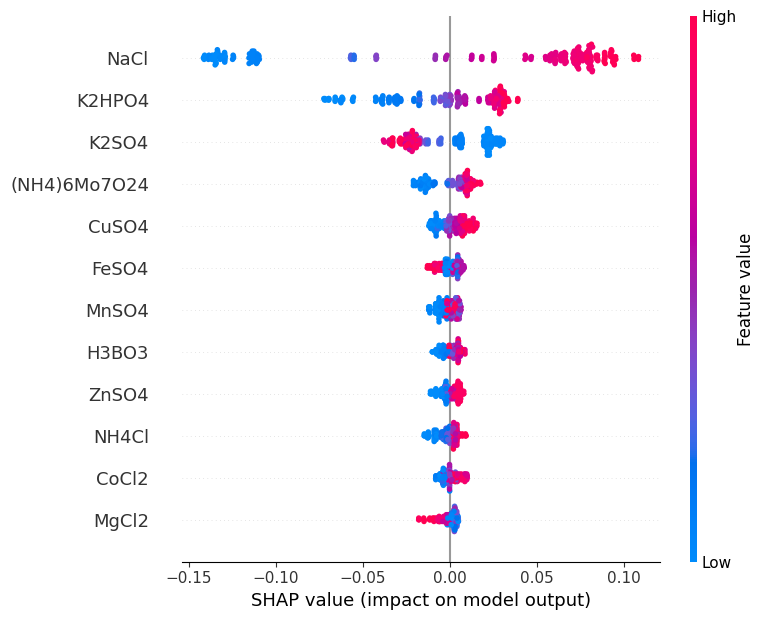

In [90]:
shap.summary_plot(shap_values_perm)

In [102]:
len(art.X)

240